## cdef class callback vs cython ode vs python ode

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from probDE.utils.utils import zero_pad
from probDE.utils.utils import root_gen
from probDE.Kalman.kalman_initial_draw import kalman_initial_draw
from probDE.Kalman import kalman_ode_higher
from probDE.Kalman.higher_mvncond import higher_mvncond
%load_ext cython

In [2]:
from math import sin
def ode_py(x_t, t):
    return np.array([sin(2*t) - x_t[0]])

In [3]:
%%cython
from libc.math cimport sin
import numpy as np
cimport numpy as np

DTYPE = np.double
ctypedef np.double_t DTYPE_t

cpdef np.ndarray[DTYPE_t, ndim=1] ode_fun(double[::1] x_t, double t):
    return np.array([sin(2*t) - x_t[0]])

cpdef rand_mat(int n, int p, bint pd=True):
    cdef np.ndarray[np.double_t, ndim=2] V = np.zeros((p, n), order='F')
    V[:] = np.random.randn(p, n)
    if (p == n) and pd:
        V[:] = np.matmul(V, V.T)
    return V

In [4]:
%%cython
from libc.math cimport sin
import numpy as np
cimport numpy as np

DTYPE = np.double
ctypedef np.double_t DTYPE_t

cdef class fun:
    cpdef ode_fun(self, double[::1] x_t, double t):
        return np.array([0])

cdef class odefun(fun):
    cpdef odefun(self, double[::1] x_t, double t):
        return np.array([sin(2*t) - x_t[0]])

In [5]:
x0_state = np.random.rand(4)
f = odefun()

In [ ]:
%timeit -o -n 1000000 ode_py(x0_state, 0)

In [ ]:
%timeit -o -n 1000000 ode_fun(x0_state, 0)

In [ ]:
%timeit -o -n 1000000 f.odefun(x0_state, 0)

## KalmanODE Class

In [6]:
from probDE.cython.KalmanTest.KalmanODE import KalmanODE

In [ ]:
%%cython
import numpy as np
cimport numpy as np
from probDE.cython.KalmanTest.kalman_ode import kalman_ode
cdef class KalmanODE:
    cdef int n_state, n_meas, n_eval
    cdef double tmin, tmax
    cdef object fun
    cdef public:
        object wgt_state
        object mu_state
        object var_state
        object wgt_meas
        object z_states
        
    def __cinit__(self, n_state, n_meas, tmin, tmax, n_eval, fun):
        self.n_state = n_state
        self.n_meas = n_meas
        self.tmin = tmin
        self.tmax = tmax
        self.n_eval = n_eval
        self.fun = fun.odefun
        self.wgt_state = None
        self.mu_state = None
        self.var_state = None
        self.wgt_meas = None
        self.z_states = None
    
    cpdef rand_mat(self, int n, int p, bint pd=True):
        cdef np.ndarray[np.double_t, ndim=2] V = np.zeros((p, n), order='F')
        V[:] = np.random.randn(p, n)
        if (p == n) and pd:
            V[:] = np.matmul(V, V.T)
        return V
        
    cpdef solve(self, double[::1] x0_state, theta=None, bint mv=False, bint sim=True):
        if (self.wgt_state is None or self.mu_state is None or 
           self.var_state is None or self.wgt_meas is None):
            raise ValueError("wgt_state, mu_state, var_state, wgt_meas is not set.")
        
        if self.z_states is None:
            self.z_states = self.rand_mat(2*self.n_eval, self.n_state)
        
        if mv and sim:
            kalman_sim, kalman_mu, kalman_var = \
                kalman_ode(self.fun, x0_state, self.tmin, self.tmax, self.n_eval,
                          self.wgt_state, self.mu_state, self.var_state,
                          self.wgt_meas, self.z_states, None, mv, sim)
            kalman_sim = np.ascontiguousarray(kalman_sim.T)
            kalman_mu = np.ascontiguousarray(kalman_mu.T)
            kalman_var = np.ascontiguousarray(kalman_var.T)
            return kalman_sim, kalman_mu, kalman_var
        elif mv:
            kalman_mu, kalman_var = \
                kalman_ode(self.fun, x0_state, self.tmin, self.tmax, self.n_eval,
                          self.wgt_state, self.mu_state, self.var_state,
                          self.wgt_meas, self.z_states, None, mv, sim)
            kalman_mu = np.ascontiguousarray(kalman_mu.T)
            kalman_var = np.ascontiguousarray(kalman_var.T)
            return kalman_mu, kalman_var
        elif sim:
            kalman_sim = \
                kalman_ode(self.fun, x0_state, self.tmin, self.tmax, self.n_eval,
                          self.wgt_state, self.mu_state, self.var_state,
                          self.wgt_meas, self.z_states, None, mv, sim)
            kalman_sim = np.ascontiguousarray(kalman_sim.T)
            return kalman_sim

In [7]:
n_steps = 50
n_eval = n_steps-1
n_meas = 1
n_state = 4
tmin = 0
tmax = 10
delta_t = np.array([(tmax-tmin)*1/n_steps])
w = np.array([0., 0., 1.])
wgt_meas = zero_pad(w, n_state)
x0 = np.array([-1., 0., 0.])
x0 = np.array([-1.0, 0.0, ode_fun(x0, 0)[0]]) #Initial state
r0 = 500
sigma = 0.5
roots = root_gen(r0,n_state) #Generate roots to draw x^{(3)}_0
x0_state = kalman_initial_draw(roots, sigma, x0, n_state)
wgt_state, var_state = higher_mvncond(delta_t, roots, sigma) 
mu_state = np.zeros(n_state)
z_states = rand_mat(2*n_steps, n_state)
python_mu, python_var = kalman_ode_higher(ode_fun, x0_state, tmin, tmax, n_eval, 
                                          wgt_state, mu_state, var_state, wgt_meas, z_states)

In [8]:
kalmanode = KalmanODE(n_state, n_meas, tmin, tmax, n_eval, f)
kalmanode.mu_state = mu_state
kalmanode.wgt_state = wgt_state
kalmanode.var_state = var_state
kalmanode.wgt_meas = wgt_meas
kalmanode.z_states = z_states
kalman_sim, kalman_mu, kalman_var, = kalmanode.solve(x0_state, mv=True, sim=True)

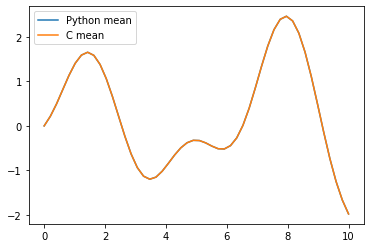

In [9]:
tseq = np.linspace(tmin, tmax, n_steps)
plt.plot(tseq, python_mu[:, 1], label = 'Python mean')
plt.plot(tseq, kalman_mu[:, 1], label = 'C mean')
plt.legend(loc='upper left')

In [10]:
kalman_cy = %timeit -o -n 100 _, _, _ = kalmanode.solve(x0_state, mv=True, sim=True)

350 µs ± 28.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## KalmanODE_py